In [27]:
#general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings as w
w('ignore')
import seaborn as sns

#misc
from datetime import datetime,date
from dateutil.relativedelta import relativedelta

#Models
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score


#Productionizing the ML model:
import pickle
#to display all rows of a dataframe in jupyter
pd.options.display.max_rows
pd.set_option('display.max_rows',None)


# Data Scraping from glassdoor
Selenium was used to scrape all the desired data from Glassdoor


In [28]:
import glassdoor_scraper as gs
dataset = gs.get_jobs('data scientist', 1000, False, '/chromedriver', 10)
data = dataset.drop(dataset.columns[0], axis=1)

# Data Cleaning

In [4]:
#remove the rows where there is '-1'
data = data[data['Salary Estimate'] != '-1']

#two columns created denoting if 'per hour' and 'employer provided salary' exists in respective rows
data['hourly'] = data['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
data['employerprovided'] = data['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)


#'per hour' and 'employed provided salary' is removed along with '$' and 'K'
data['Salary Estimate'] = data['Salary Estimate'].apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary:','').replace('$','').replace('k',''))


#the salary range is separated from the bracketed text - (glassdoor est)
data['Salary Estimate'] = data['Salary Estimate'].apply(lambda x: x.split('(')[0])


#hyphen is removed and left side and right side of the salary are separated in min and max salary
data['min_salary'] = data['Salary Estimate'].apply(lambda x: x.split('-')[0]).apply(lambda x: int(x))
data['max_salary'] = data['Salary Estimate'].apply(lambda x: x.split('-')[1]).apply(lambda x: int(x))



#average salary
data['avg_salary'] = data[['min_salary','max_salary']].mean(axis=1)


#'Company Name': Now, let's retain only company text in "company name" field
data['company_name_text'] = data.apply(lambda x: x['Company Name'] if x['Rating'] < 1 else x['Company Name'][0:-4], axis=1)


#'Location':  Only the state name is retained in the location column
data['state'] = data['Location'].apply(lambda x: x.split(',')[1])
#to view how many companies are there in each state
#data['state'].value_counts() #a good way to check for outliers


#Founded: Will calculate and store the age of the Company 
data['company_age'] = data['Founded'].apply(lambda x: datetime.now().year - x if x!=-1 else x)



#Headquarters and state: will find out if the location of the job is the headquarters
data['same_location'] = data.apply(lambda x: 1 if x['state'] in x['Headquarters'] else 0 , axis=1)



#Job Description: If certain important data science tools exist, insert 1
#tools: python, SQL, R, excel, sas, hadoop
data['python'] = data['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
data['sql'] = data['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
data['tableau'] = data['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)
data['excel'] = data['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
data['sas'] = data['Job Description'].apply(lambda x: 1 if 'sas' in x.lower() else 0)
data['hadoop'] = data['Job Description'].apply(lambda x: 1 if 'hadoop' in x.lower() else 0)

data['python'].value_counts()


#Checking in the job title for role names
data['job_title_simple'] = data['Job Title'].apply(lambda x: 'analyst' if 'analyst' in x.lower() else 'data scientist' if 'data scientist' in x.lower() else 'ML engineer' if 'machine learning engineer' in x.lower() else 'manager' if 'manager' in x.lower() else 'director' if 'director' in x.lower() else 'data engineer' if 'data engineer' in x.lower() else "na")

#'Job Title': Checking in the job title if positions like 'senior','junior', 'director' etc exists
data['seniority'] = data['Job Title'].apply(lambda x: 'senior' if 'sr' in x.lower() or 'senior' in x.lower() or 'sr.' in x.lower() or 'lead' in x.lower() or 'principal' in x.lower() else 'junior' if 'jr' in x.lower() or 'junior' in x.lower() or 'jr.' in x.lower() else 'na')


#'state': In the state column, los angeles in mentioned. this should be handled as LA is not a state. strip() method removes all spaces on left and right side of the string 
data['state'] = data['state'].apply(lambda x: 'CA' if x.strip().lower() == 'los angeles' else x.strip())


#'Job Description': retrieve the job description length as we can check if longer job descriptions have higher salaries
data['job_desc_len'] = data['Job Description'].apply(lambda x: len(x))


#'Competitors: we can also retrieve the no of competitors each company has:
data['competitors_num'] = data['Competitors'].apply(lambda x: len(x.split(',')) if x!= '-1' else 0) 


#change hourly salary to yearly salary. *2000 is done because there are 2000 hours in a year. /1000 is done as only first 2 digits are displayed in the column
data['min_salary'] = data.apply(lambda x: (x['min_salary']*2000)/1000 if x['hourly']==1 else x['min_salary'], axis=1)
data['max_salary'] = data.apply(lambda x: (x['max_salary']*2000)/1000 if x['hourly']==1 else x['max_salary'], axis=1)
data['avg_salary'] = data[['min_salary','max_salary']].mean(axis=1)



#'Type of Ownership': change company-public to public and company-private to private
data['Type of ownership'] = data['Type of ownership'].apply(lambda x: 'Public' if 'public' in x.lower() else 'Private' if 'private' in x.lower() else x)

# EDA

In [5]:
#Statist
data.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employerprovided', 'min_salary', 'max_salary', 'avg_salary',
       'company_name_text', 'state', 'company_age', 'same_location', 'python',
       'sql', 'tableau', 'excel', 'sas', 'hadoop', 'job_title_simple',
       'seniority', 'job_desc_len', 'competitors_num'],
      dtype='object')

In [6]:
#correlations between important columns:
data[['company_age','Rating','job_desc_len','avg_salary']].corr()
#sns.heatmap(, annot = True)

,company_age,Rating,job_desc_len,avg_salary
company_age,1.000000,0.021655,0.163911,0.021996
Rating,0.021655,1.000000,-0.012281,0.012517
job_desc_len,0.163911,-0.012281,1.000000,0.070474
avg_salary,0.021996,0.012517,0.070474,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f945d81bfd0>,
      dtype=object)

<Figure size 576x1440 with 0 Axes>

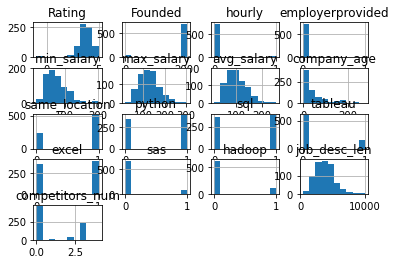

In [7]:
#histogram. if the variables are not normally distrubuted, it should be done for regression problems
plt.figure(figsize = [8,20])
data.hist()
#plt.tight_layout()

In [9]:
#bar graph for categorical columns
data_cat = data[['Location', 'Headquarters','Size',
       'Type of ownership', 'Industry', 'Sector', 'Revenue',
       'company_name_text', 'state', 'company_age', 'same_location', 'python',
       'sql', 'tableau', 'excel', 'sas', 'hadoop', 'job_title_simple',
       'seniority', 'job_desc_len', 'competitors_num']]

The total no of Locations are: 200


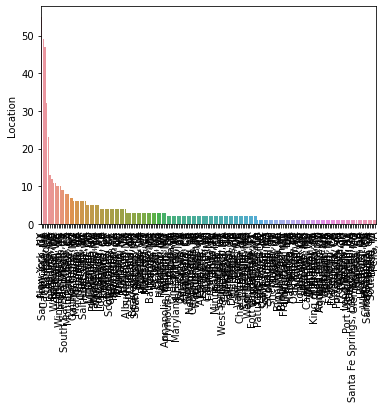

The total no of Headquarterss are: 198


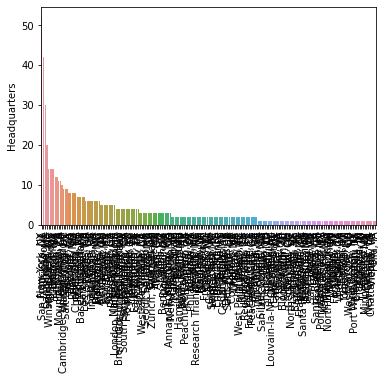

The total no of Sizes are: 9


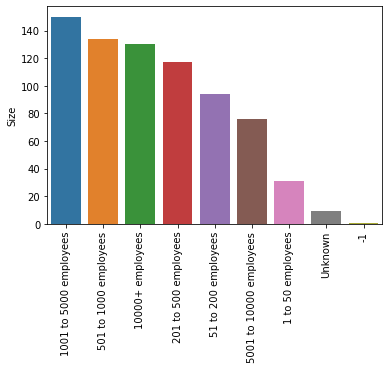

The total no of Type of ownerships are: 11


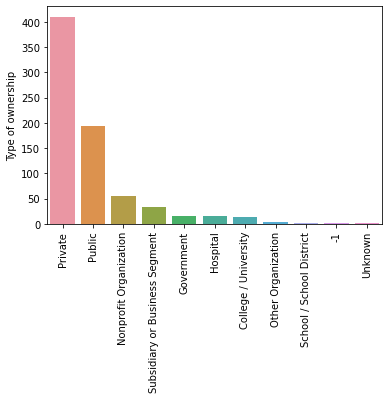

The total no of Industrys are: 60


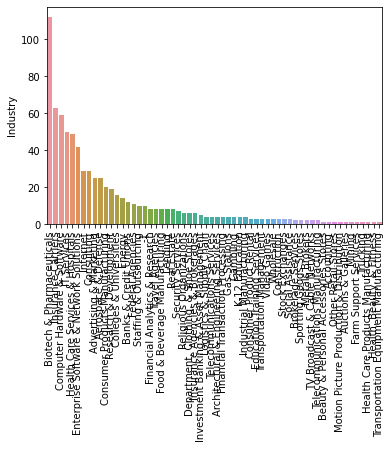

The total no of Sectors are: 25


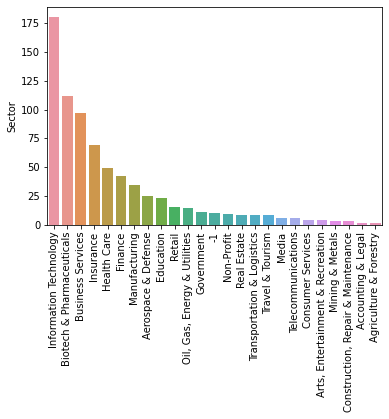

The total no of Revenues are: 14


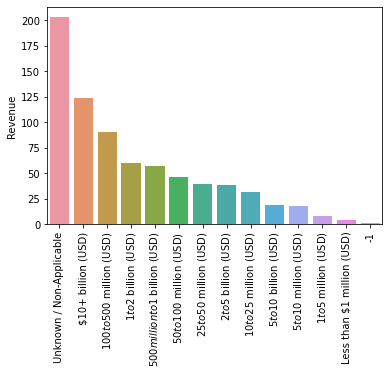

The total no of company_name_texts are: 343


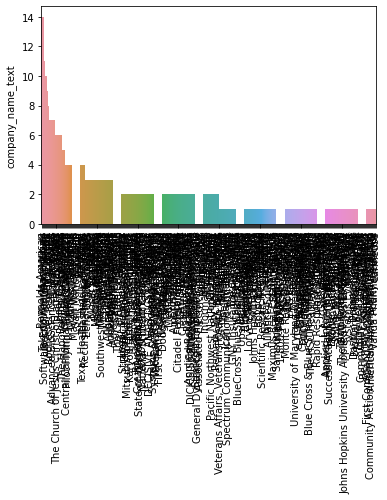

The total no of states are: 37


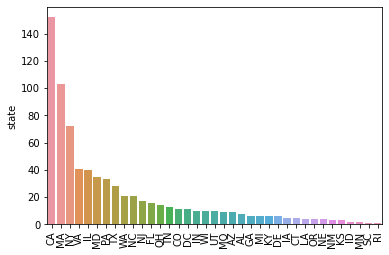

The total no of company_ages are: 102


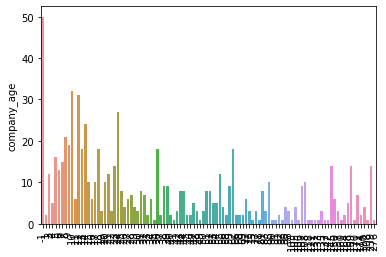

The total no of same_locations are: 2


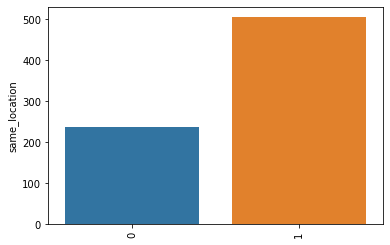

The total no of pythons are: 2


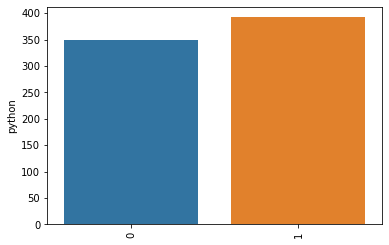

The total no of sqls are: 2


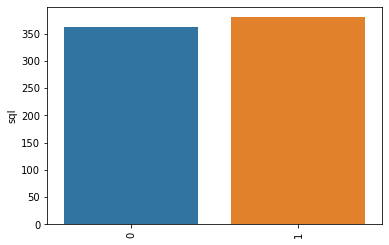

The total no of tableaus are: 2


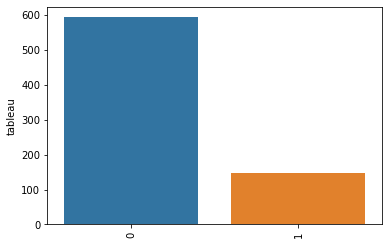

The total no of excels are: 2


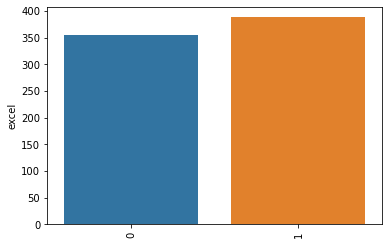

The total no of sass are: 2


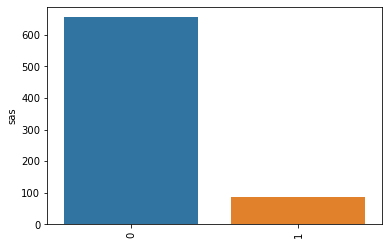

The total no of hadoops are: 2


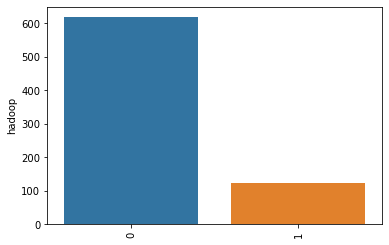

The total no of job_title_simples are: 7


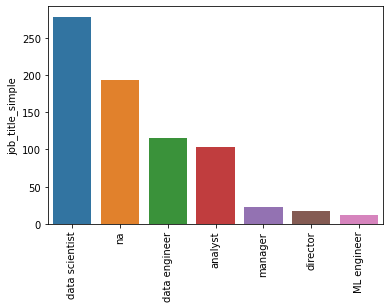

The total no of senioritys are: 3


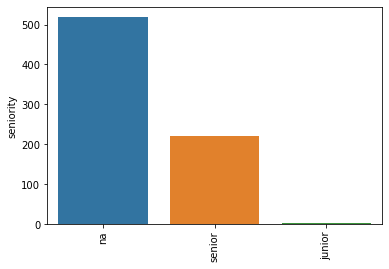

The total no of job_desc_lens are: 443


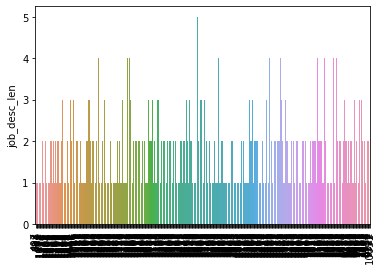

The total no of competitors_nums are: 5


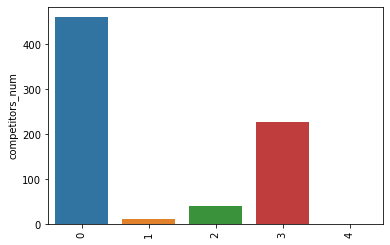

In [10]:
#cat_num = data_cat.value_counts()
for i in data_cat.columns:
    cat_num = data_cat[i].value_counts()
    print("The total no of %ss are: %d" %(i,len(cat_num)))
    graph = sns.barplot(x=cat_num.index, y = cat_num)
    graph.set_xticklabels(graph.get_xticklabels(), rotation = 90)
    plt.show()

In [11]:
#we can check which roles have what salaries
pd.pivot_table(data, index = ['state', 'job_title_simple'], values = 'avg_salary', aggfunc = 'count').sort_values('state', ascending = False)

avg_salary
state job_title_simple            
WI    na                         4
      data scientist             3
      analyst                    3
WA    na                         1
      data scientist            17
      analyst                    3
VA    na                         5
      data scientist            18
      data engineer             10
      analyst                    6
      ML engineer                2
UT    data engineer              3
      analyst                    4
      data scientist             3
TX    na                         7
      data scientist            13
      data engineer              8
TN    data scientist             1
      data engineer             10
      analyst                    2
SC    na                         1
RI    analyst                    1
PA    data scientist             6
      data engineer              1
      analyst                    8
      manager                    3
      na                        15
OR    data scientist             3
      data engineer              1
OH    na                         3
      data scientist             7
      analyst                    4
NY    na                        12
      data scientist            40
      data engineer              4
      analyst                   14
      ML engineer                2
NM    data scientist             3
NJ    data scientist             4
      analyst                    6
      data engineer              2
      manager                    2
      director                   2
      na                         1
NE    na                         4
NC    na                        12
      data scientist             3
      data engineer              6
MO    na                         3
      manager                    1
      data scientist             3
      analyst                    2
MN    data engineer              1
      analyst                    1
MI    manager                    2
      data scientist             4
MD    na                        16
      data scientist            13
      data engineer              3
      analyst                    3
MA    na                        46
      manager                    5
      director                   9
      data scientist            30
      data engineer              9
      analyst                    4
LA    analyst                    1
      na                         1
      data engineer              2
KY    data scientist             2
      na                         4
KS    ML engineer                3
IN    na                         4
      data scientist             2
      data engineer              4
IL    na                         8
      director                   6
      data scientist            15
      data engineer              7
      analyst                    4
ID    analyst                    2
IA    data engineer              3
      analyst                    2
GA    data scientist             3
      na                         3
FL    data scientist             7
      data engineer              3
      analyst                    6
DE    na                         6
DC    data scientist             5
      data engineer              4
      analyst                    2
CT    na                         3
      data scientist             2
CO    data engineer              3
      ML engineer                1
      analyst                    1
      data scientist             3
      na                         3
CA    na                        28
      manager                    9
      data scientist            68
      data engineer             25
      analyst                   18
      ML engineer                4
AZ    data scientist             1
      data engineer              5
      analyst                    1
      na                         2
AL    na                         2
      data engineer              1
      analyst                    5

In [12]:
#pivoting for only data scientists
pd.pivot_table(data[data['job_title_simple']=='data scientist'], index = 'state', values = 'avg_salary').sort_values('avg_salary', ascending = False)

,avg_salary
state,
DC,149.000000
CA,142.522059
UT,140.500000
MO,127.666667
IL,117.233333
NC,117.000000
NY,115.250000
MA,113.750000
WI,113.500000


In [13]:
data_pivots = data[['Rating','Industry','Sector','Revenue','competitors_num','python','sql','sas','tableau','excel','hadoop','Type of ownership','avg_salary']]


In [14]:
#construct pivot tables for all the columns in the above data_pivots against 'avg_salary'
for i in data_pivots.columns:
    print(i)
    print(pd.pivot_table(data_pivots, index=i, values = 'avg_salary').sort_values('avg_salary', ascending=False))


"\nfor i in data_pivots.columns:\n    print(i)\n    print(pd.pivot_table(data_pivots, index=i, values = 'avg_salary').sort_values('avg_salary', ascending=False))\n"

# Model Building

In [16]:
#selecting relevant columns:
data_model = data[['Rating','Size','Type of ownership', 'Industry', 'Sector', 'Revenue','hourly', 'employerprovided','state','same_location','company_age','python', 'sql', 'tableau', 'excel', 'sas', 'hadoop', 'job_title_simple', 'seniority', 'job_desc_len', 'competitors_num','avg_salary',]]

In [17]:
data_model.head(60)

,Rating,Size,Type of ownership,Industry,Sector,Revenue,hourly,employerprovided,state,same_location,...,sql,tableau,excel,sas,hadoop,job_title_simple,seniority,job_desc_len,competitors_num,avg_salary
0,3.8,501 to 1000 employees,Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),0,0,NM,0,...,0,1,1,1,0,data scientist,na,2536,0,72.0
1,3.4,10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),0,0,MD,1,...,0,0,0,0,0,data scientist,na,4783,0,87.5
2,4.8,501 to 1000 employees,Private,Security Services,Business Services,$100 to $500 million (USD),0,0,FL,1,...,1,0,1,1,0,data scientist,na,3461,0,85.0
3,3.8,1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),0,0,WA,1,...,0,0,0,0,0,data scientist,na,3883,3,76.5
4,2.9,51 to 200 employees,Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,0,0,NY,1,...,1,0,1,1,0,data scientist,na,2728,3,114.5
5,3.4,201 to 500 employees,Public,Real Estate,Real Estate,$1 to $2 billion (USD),0,0,TX,1,...,1,0,1,0,0,data scientist,na,3747,3,95.0
6,4.1,501 to 1000 employees,Private,Banks & Credit Unions,Finance,Unknown / Non-Applicable,0,0,MD,1,...,0,0,1,0,0,data scientist,na,1786,0,73.5
7,3.8,201 to 500 employees,Private,Consulting,Business Services,$25 to $50 million (USD),0,0,CA,0,...,1,0,1,0,0,data scientist,na,3804,0,114.0
8,3.3,10000+ employees,Hospital,Health Care Services & Hospitals,Health Care,$500 million to $1 billion (USD),0,0,NY,1,...,0,0,0,0,0,na,na,1538,0,61.0
9,4.6,51 to 200 employees,Private,Internet,Information Technology,$100 to $500 million (USD),0,0,NY,1,...,0,0,0,0,0,data scientist,na,4574,2,140.0


In [18]:
#creating dummies for categorical variables
data_dummies = pd.get_dummies(data_model)
data_dummies[['Rating','avg_salary']].head(20)

,Rating,avg_salary
0,3.8,72.0
1,3.4,87.5
2,4.8,85.0
3,3.8,76.5
4,2.9,114.5
5,3.4,95.0
6,4.1,73.5
7,3.8,114.0
8,3.3,61.0
9,4.6,140.0


In [19]:
#splitting dependant and dependant variables and then creating train and test set
x = data_dummies.drop('avg_salary', axis=1)
y = data_dummies['avg_salary'].values.reshape(-1,1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.2, random_state=0)

LM normal:  -20.07470195553596
lasso:  -19.217339133979884
the error and alpha value for best lasso:         error  alpha
3 -19.217339   0.04


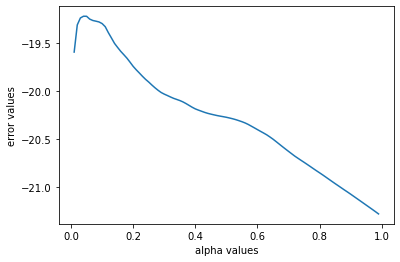

In [20]:
#model1: Multi linear regression
#using statsmodels:
x_sm = sm.add_constant(x) 
model1 = sm.OLS(y,x_sm)
model1.fit().summary()

#using sklearn
lm = LinearRegression()
lm.fit(xtrain,ytrain)
print("LM normal: ",np.mean(cross_val_score(lm, xtrain,ytrain, scoring= 'neg_mean_absolute_error', cv=3)))


#using lasso regression 
lasso = Lasso(alpha =0.04) #alpha=1 is default
lasso.fit(xtrain,ytrain)
print("lasso: ",np.mean(cross_val_score(lasso, xtrain,ytrain, scoring= 'neg_mean_absolute_error', cv=3)))
#let's try different alpha values by using a for loop

alpha=[]
error = []
for i in np.arange(0.01,1,0.01):
    alpha.append(i)
    lm_lasso = Lasso(alpha=i)
    error.append(np.mean(cross_val_score(lm_lasso, xtrain,ytrain, scoring= 'neg_mean_absolute_error', cv=3)))
    
                            
plt.plot(alpha,error)
plt.xlabel("alpha values")
plt.ylabel("error values")

#the peak of the graph would be the the optimum alpha value. to retrieve, put the lists in a df and find max(error)
tup = tuple(zip(error,alpha))
df_err = pd.DataFrame(tup, columns = ['error','alpha'])
opt_alpha =  df_err[df_err['error']==max(df_err['error'])]
print("the error and alpha value for best lasso: ",opt_alpha)

In [21]:
#Random Forest
rf = RandomForestRegressor(criterion =  'mse', max_features =  'auto', n_estimators =  300)
print("For default rf, the error is:", np.mean(cross_val_score(rf,xtrain,ytrain,scoring = 'neg_mean_absolute_error',cv = 3)))
print("For default rf, the r2_score is:", np.mean(cross_val_score(rf,xtrain,ytrain,cv = 3)))
rf.fit(xtrain,ytrain)

For default rf, the error is: -13.986537227890866
For default rf, the r2_score is: 0.6867855239934105
r2 for RF is:  0.6472226019310339
adj r2 for RF is:  2.6842275778776448


In [22]:
#Hyperparameter Tuning using GridSearch
rf_gs = RandomForestRegressor()
params = {'criterion' : ['mse','mae'], 'n_estimators':[100,300,400,500], 'max_features':['auto','sqrt','log2']} 
grid_model = GridSearchCV(rf_gs, cv=3, param_grid = params, scoring = 'neg_mean_absolute_error')
grid_model.fit(xtrain,ytrain)
print("error after grid search: ", grid_model.best_score_)
print("The parameters given by the grid searchh is:", grid_model.best_params_)


'\nrf_gs = RandomForestRegressor()\nparams = {\'criterion\' : [\'mse\',\'mae\'], \'n_estimators\':[100,300,400,500], \'max_features\':[\'auto\',\'sqrt\',\'log2\']} \ngrid_model = GridSearchCV(rf_gs, cv=3, param_grid = params, scoring = \'neg_mean_absolute_error\')\ngrid_model.fit(xtrain,ytrain)\nprint("error after grid search: ", grid_model.best_score_)\nprint("The parameters given by the grid searchh is:", grid_model.best_params_)\n'

In [23]:
#predicting on the test sets.
print("mae for LM is: ", mean_absolute_error(ytest, lm.predict(xtest)))
print("mae for Lasso is: ", mean_absolute_error(ytest, lasso.predict(xtest)))
print("mae for RF is: ", mean_absolute_error(ytest, grid_model.best_estimator_.predict(xtest)))
print("r2 for RF is: ", r2_score(ytest, grid_model.best_estimator_.predict(xtest)))


'''
mae for LM is:  19.09621634412441
mae for Lasso is:  18.87340281254084
mae for RF is:  12.691744966442952 #grid model
'''

'\nprint("mae for LM is: ", mean_absolute_error(ytest, lm.predict(xtest)))\nprint("mae for Lasso is: ", mean_absolute_error(ytest, lasso.predict(xtest)))\nprint("mae for RF is: ", mean_absolute_error(ytest, grid_model.best_estimator_.predict(xtest)))\nprint("r2 for RF is: ", r2_score(ytest, grid_model.best_estimator_.predict(xtest)))\nprint("adj r2 for RF is: ", adjusted_r2(ytest, grid_model.best_estimator_.predict(xtest), xtest))\n\n\nmae for LM is:  19.09621634412441\nmae for Lasso is:  18.87340281254084\nmae for RF is:  12.691744966442952 #grid model\n'

# Productionization

productionization: create a flask api endpoint, where job information is sent and the API returns the salary

In [24]:
import pickle
#create a pickle file from the model. the below lines store it in the same directory as the code file
pickl = {'model': grid_model.best_estimator_}
pickle.dump(pickl, open('model_file' + ".p","wb"))


'\n#create a pickle file from the model. the below lines store it in the same directory as the code file\npickl = {\'model\': grid_model.best_estimator_}\npickle.dump(pickl, open(\'model_file\' + ".p","wb"))\n'

In [25]:
#loading the model from the pickle
file_name = "models/model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model'] #pickled model is saved in model now
    
model.predict(xtest.iloc[0,:].values.reshape(1,-1)) 


'\nfile_name = "models/model_file.p"\nwith open(file_name, \'rb\') as pickled:\n    data = pickle.load(pickled)\n    model = data[\'model\'] #pickled model is saved in model now\n    \nmodel.predict(xtest.iloc[0,:].values.reshape(1,-1)) #we check here if the model was loaded correctly.\n'